### Using ISR Address

In [8]:
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
from shapely.geometry import Point, box
import geopandas as gpd
import os

# Define the three Ann Arbor coordinates
coordinates = [
    {
        'name': 'Hidden Valley Club Dr',
        'latitude': 42.24622079971437, 
        'longitude': -83.74239629820643
    },
    {
        'name': 'ISR',
        'latitude': 42.27668144786866,
        'longitude': -83.74358947405014
    },
    {
        'name': 'Sunghee',
        'latitude': 42.314663999415906,
        'longitude': -83.66006875455071
    }
]

# File paths
nlcd_file = r"C:\Users\sybox\NIJ Detroit\Annual_NLCD_LndCov_2022_CU_C1V1.tif"
subset_file = "ann_arbor_nlcd_subset.tif"

# Green land cover classes
GREEN_CLASSES = {
    21: "Developed, Open Space",
    41: "Deciduous Forest",
    42: "Evergreen Forest", 
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Grassland/Herbaceous",
    81: "Pasture/Hay",
    82: "Cultivated Crops"
}

def create_ann_arbor_subset(input_file, coordinates, output_file='ann_arbor_nlcd.tif', buffer_miles=5):
    """Create a small subset of NLCD just for Ann Arbor area"""
    
    print("Creating Ann Arbor subset...")
    
    # Get bounds from coordinates with buffer
    lats = [c['latitude'] for c in coordinates]
    lons = [c['longitude'] for c in coordinates]
    buffer_deg = buffer_miles / 69
    
    bbox = box(
        min(lons) - buffer_deg,
        min(lats) - buffer_deg,
        max(lons) + buffer_deg,
        max(lats) + buffer_deg
    )
    
    gdf = gpd.GeoDataFrame([1], geometry=[bbox], crs='EPSG:4326')
    
    with rasterio.open(input_file) as src:
        gdf_albers = gdf.to_crs(src.crs)
        window = from_bounds(
            gdf_albers.total_bounds[0],
            gdf_albers.total_bounds[1], 
            gdf_albers.total_bounds[2],
            gdf_albers.total_bounds[3],
            src.transform
        )
        
        subset_data = src.read(1, window=window)
        subset_transform = src.window_transform(window)
        
        out_meta = src.meta.copy()
        out_meta.update({
            "driver": "GTiff",
            "height": subset_data.shape[0],
            "width": subset_data.shape[1],
            "transform": subset_transform,
            "compress": "lzw"
        })
        
        with rasterio.open(output_file, "w", **out_meta) as dest:
            dest.write(subset_data, 1)
    
    file_size_mb = os.path.getsize(output_file) / (1024**2)
    print(f"Created subset: {output_file} ({file_size_mb:.1f} MB)")
    return output_file

def analyze_greenness(coordinates, nlcd_file_path, radius_miles=1):
    """Analyze greenness for coordinates"""
    
    print(f"\nAnalyzing {len(coordinates)} locations...")
    
    with rasterio.open(nlcd_file_path) as src:
        nlcd_crs = src.crs
        bbox_data = src.read(1)
        bbox_transform = src.transform
        bbox_profile = src.profile.copy()
    
    results = []
    radius_meters = radius_miles * 1609.34
    
    for location in coordinates:
        # Create point and buffer
        point_wgs84 = Point(location['longitude'], location['latitude'])
        gdf_wgs84 = gpd.GeoDataFrame([1], geometry=[point_wgs84], crs='EPSG:4326')
        gdf_albers = gdf_wgs84.to_crs(nlcd_crs)
        buffer_albers = gdf_albers.buffer(radius_meters)
        
        # Mask the data with the buffer
        from rasterio.io import MemoryFile
        with MemoryFile() as memfile:
            with memfile.open(**bbox_profile) as temp_dataset:
                temp_dataset.write(bbox_data.astype(np.int32), 1)
                clipped_data, _ = mask(
                    temp_dataset,
                    buffer_albers.geometry,
                    crop=True,
                    nodata=0
                )
                clipped_data = clipped_data[0]
        
        # Calculate statistics
        valid_pixels = clipped_data[clipped_data != 0]
        total_pixels = len(valid_pixels)
        green_pixels = np.sum(np.isin(valid_pixels, list(GREEN_CLASSES.keys())))
        green_percentage = (green_pixels / total_pixels) * 100
        
        # Get breakdown by category
        unique_values, counts = np.unique(valid_pixels, return_counts=True)
        green_breakdown = {}
        
        for value, count in zip(unique_values, counts):
            if value in GREEN_CLASSES:
                percentage = (count / total_pixels) * 100
                green_breakdown[GREEN_CLASSES[value]] = round(percentage, 2)
        
        results.append({
            'name': location['name'],
            'green_percentage': round(green_percentage, 2),
            'breakdown': green_breakdown
        })
    
    return results

# ============================================================
# RUN ANALYSIS
# ============================================================

# Create subset if it doesn't exist
if not os.path.exists(subset_file):
    subset_file = create_ann_arbor_subset(nlcd_file, coordinates, subset_file)
else:
    print(f"Using existing subset: {subset_file}")

# Run analysis
results = analyze_greenness(coordinates, subset_file)

# Display results
print("\n" + "="*50)
print("GREENNESS RESULTS")
print("="*50)

for result in results:
    print(f"\n{result['name']}:")
    print(f"  Total Greenness: {result['green_percentage']}%")
    
    if result['breakdown']:
        print("  Breakdown by category:")
        for category, percent in sorted(result['breakdown'].items(), key=lambda x: x[1], reverse=True):
            print(f"    • {category}: {percent}%")

Using existing subset: ann_arbor_nlcd_subset.tif

Analyzing 3 locations...

GREENNESS RESULTS

Hidden Valley Club Dr:
  Total Greenness: 14.86%
  Breakdown by category:
    • Developed, Open Space: 13.86%
    • Deciduous Forest: 1.01%

ISR:
  Total Greenness: 9.73%
  Breakdown by category:
    • Developed, Open Space: 8.95%
    • Deciduous Forest: 0.7%
    • Mixed Forest: 0.08%

Sunghee:
  Total Greenness: 60.6%
  Breakdown by category:
    • Deciduous Forest: 34.85%
    • Developed, Open Space: 21.11%
    • Mixed Forest: 2.41%
    • Pasture/Hay: 1.86%
    • Evergreen Forest: 0.32%
    • Grassland/Herbaceous: 0.03%
    • Cultivated Crops: 0.01%


In [7]:
# Create the Ann Arbor area subset (only needs to be done once)
subset_file = create_ann_arbor_subset(nlcd_file, coordinates, 'ann_arbor_nlcd_subset.tif')

# Validate the subset covers your locations
validate_regional_file_fixed(subset_file, coordinates)

# Run the analysis on the smaller subset file (will be FAST!)
results = analyze_coordinates_with_bbox(coordinates, subset_file)

# Create visualizations
create_coordinate_comparison_chart(results)
create_coordinate_detailed_report(results)

🔄 Creating Ann Arbor area subset from large NLCD file...
📍 Bounding box (WGS84):
   West: -83.8493, South: 42.1970
   East: -83.5876, North: 42.3871
📂 Opening large NLCD file...
   Original dimensions: 160000 × 105000 pixels
🔍 Extracting subset...
   Subset dimensions: 800 × 795 pixels

✅ Created subset file: ann_arbor_nlcd_subset.tif
💾 File size: 0.1 MB (vs original 1366 MB)
🎯 This file covers just the Ann Arbor area with a 5-mile buffer


NameError: name 'validate_regional_file_fixed' is not defined

### Using HAWK addresses-Greenness (Forrest only)

In [1]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
from shapely.geometry import Point
import geopandas as gpd
import time

from rasterio.io import MemoryFile

# Function to run analysis for one year/dataset
def run_analysis(address_file, nlcd_file, output_file, green_classes, radius_meters=1609.34):
    print(f"\n📂 Reading address file: {address_file}")
    df = pd.read_csv(address_file)
    print(f"✅ Found {len(df)} addresses")
    print(f"📋 Columns: {df.columns.tolist()}")
    
    print(f"\n🔍 Checking coordinates...")
    print(f"  LATITUDE range: {df['LATITUDE'].min():.4f} to {df['LATITUDE'].max():.4f}")
    print(f"  LONGITUDE range: {df['LONGITUDE'].min():.4f} to {df['LONGITUDE'].max():.4f}")

    results = []
    errors = []
    successes = 0

    print(f"\n🌱 Starting greenness analysis for {output_file} ...")
    print("=" * 50)
    start_time = time.time()

    with rasterio.open(nlcd_file) as src:
        nlcd_crs = src.crs
        print(f"📊 NLCD CRS: {nlcd_crs}")
        
        for idx, row in df.iterrows():
            if idx % 10 == 0:
                elapsed = time.time() - start_time
                if idx > 0:
                    rate = elapsed / idx
                    remaining = (len(df) - idx) * rate
                    print(f"Processing {idx+1}/{len(df)}... (~{remaining/60:.1f} min remaining)")
                else:
                    print(f"Processing {idx+1}/{len(df)}...")
            try:
                lat = float(row['LATITUDE'])
                lon = float(row['LONGITUDE'])
                point = Point(lon, lat)
                gdf = gpd.GeoDataFrame([1], geometry=[point], crs='EPSG:4326')
                gdf_albers = gdf.to_crs(nlcd_crs)
                buffer = gdf_albers.buffer(radius_meters)
                bounds = buffer.total_bounds
                window = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], src.transform)
                if window.col_off < 0 or window.row_off < 0:
                    errors.append(f"Row {idx}: Location outside NLCD coverage")
                    results.append(np.nan)
                    continue
                local_data = src.read(1, window=window)
                if local_data.size == 0:
                    errors.append(f"Row {idx}: No data at this location")
                    results.append(np.nan)
                    continue
                local_transform = src.window_transform(window)
                with MemoryFile() as memfile:
                    profile = src.profile.copy()
                    profile.update({
                        'height': local_data.shape[0],
                        'width': local_data.shape[1],
                        'transform': local_transform,
                        'dtype': 'int32'
                    })
                    with memfile.open(**profile) as temp_src:
                        temp_src.write(local_data.astype(np.int32), 1)
                        clipped_data, _ = mask(temp_src, buffer.geometry, crop=True, nodata=0)
                        clipped_data = clipped_data[0]
                valid_pixels = clipped_data[clipped_data != 0]
                if len(valid_pixels) == 0:
                    errors.append(f"Row {idx}: No valid pixels in buffer")
                    results.append(np.nan)
                    continue
                total_pixels = len(valid_pixels)
                green_pixels = np.sum(np.isin(valid_pixels, list(green_classes.keys())))
                green_percentage = (green_pixels / total_pixels) * 100
                results.append(round(green_percentage, 2))
                successes += 1
                if successes == 1:
                    print(f"\n  ✅ First successful analysis for {output_file}:")
                    print(f"     Location: ({lat:.4f}, {lon:.4f})")
                    print(f"     Total pixels: {total_pixels}")
                    print(f"     Green pixels: {green_pixels}")
                    print(f"     Green %: {green_percentage:.2f}%")
            except Exception as e:
                errors.append(f"Row {idx}: {str(e)[:50]}")
                results.append(np.nan)
        output_df = pd.DataFrame({'green_percentage': results})
        output_df.to_excel(output_file, index=False)
        total_time = time.time() - start_time
        print(f"\n" + "="*50)
        print(f"✅ Analysis complete for {output_file}!")
        print(f"⏱️  Total time: {total_time/60:.1f} min ({total_time/len(df):.1f}s/address)")
        print(f"✅ Successful analyses: {successes}/{len(df)}")
        if successes > 0:
            green_values = [r for r in results if not pd.isna(r)]
            print(f"🌲 Forest greenness avg: {np.mean(green_values):.1f}%")
            print(f"   Min: {np.min(green_values):.1f}%")
            print(f"   Max: {np.max(green_values):.1f}%")
            print(f"   Median: {np.median(green_values):.1f}%")
        if errors:
            print(f"\n⚠️  Found {len(errors)} errors. First few:")
            for error in errors[:5]:
                print(f"   {error}")
        print(f"\n💡 Output file contains only the 'green_percentage' column for {output_file}.")

# Updated forest classes only
GREEN_FOREST_CLASSES = {
    41: "Deciduous Forest",
    42: "Evergreen Forest",
    43: "Mixed Forest"
}

# File paths for both years
address_file_2022 = r"C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Raw_2022_wAddress.csv"
nlcd_file_2022 = r"C:\Users\sybox\NIJ Detroit\Annual_NLCD_LndCov_2022_CU_C1V1.tif"
output_file_2022 = 'greenness_results_2022_forest.xlsx'

address_file_2023 = r"C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Raw_2023_wAddress.csv"
nlcd_file_2023 = r"C:\Users\sybox\NIJ Detroit\Annual_NLCD_LndCov_2023_CU_C1V1.tif"
output_file_2023 = 'greenness_results_2023_forest.xlsx'

# Run for 2022
run_analysis(address_file_2022, nlcd_file_2022, output_file_2022, GREEN_FOREST_CLASSES)

# Run for 2023
run_analysis(address_file_2023, nlcd_file_2023, output_file_2023, GREEN_FOREST_CLASSES)


📂 Reading address file: C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Raw_2022_wAddress.csv
✅ Found 511 addresses
📋 Columns: ['RECRUITER_ID', 'SEED_ID', 'WAVE', 'SEED', 'SEED_MAIL', 'C1_0', 'C1_1', 'C2', 'C3', 'C4', 'C5', 'C11', 'C6', 'C7', 'C8', 'C9', 'C10', 'C13_1', 'C14_1', 'C15_1', 'C16_1', 'C17_1', 'C13_2', 'C14_2', 'C15_2', 'C16_2', 'C17_2', 'C13_3', 'C14_3', 'C15_3', 'C16_3', 'C17_3', 'C13_4', 'C14_4', 'C15_4', 'C16_4', 'C17_4', 'E5_1_1', 'E5_1_2', 'E5_EX_1', 'E5_EX_2', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'A2', 'A2_REL', 'AGE', 'SEX', 'B2', 'B4', 'B5', 'B7', 'N3', 'BMI', 'E1', 'E2', 'CV1', 'CV1_1', 'CV3_ANSWERED', 'CV3_MASK', 'CV3_WASH_HANDS', 'CV3_HAND_SANITIZER', 'CV3_GLOVES', 'CV3_MIN_OUTINGS', 'CV3_DISINFECT_HOUSE', 'CV3_SOCIAL_DIST', 'CV3_STAY_HOME', 'CV3_AVOID_TOUCH_FACE', 'CV3_VITAMINS', 'CV3_TYLENOL_ASPIRIN', 'CV3_NO_PREVENT', 'CV4_ANSWERED', 'CV4_NO_HEALTHCARE', 'CV4_LOST_JOB', 'CV4_WORK_HOME', 'CV4_LOST_INCOME', 'CV4_DISRUPT_EDUCATION', 'CV4_WORRY_GOTO

### 11.06 Visualization

In [1]:
import pandas as pd

g = pd.read_excel('greenness_results_2022_forest.xlsx')
print(g['green_percentage'].describe())

# pick one high-green and one low-green example
high_idx = g['green_percentage'].idxmax()
low_idx = g['green_percentage'].idxmin()

high_green = g.loc[high_idx]
low_green = g.loc[low_idx]
print("High green:", high_green)
print("Low green:", low_green)


count    503.000000
mean       5.636262
std        9.646139
min        0.000000
25%        0.000000
50%        0.760000
75%        7.510000
max       83.610000
Name: green_percentage, dtype: float64
High green: green_percentage    83.61
Name: 100, dtype: float64
Low green: green_percentage    0.0
Name: 3, dtype: float64


High greenness example:
                                      ADDRESS   LATITUDE  LONGITUDE  \
100  834 Upper Standing Rock Rd, Dover, 37058  36.416342 -87.909436   
100  834 Upper Standing Rock Rd, Dover, 37058  36.416342 -87.909436   

     green_percentage  green_percentage  
100             83.61             83.61  
100             83.61             83.61  

Low greenness example:
                                       ADDRESS   LATITUDE  LONGITUDE  \
3  777 S Third Street APT 1040, Harrison, 7029  40.740298 -74.157738   
3  777 S Third Street APT 1040, Harrison, 7029  40.740298 -74.157738   

   green_percentage  green_percentage  
3               0.0               0.0  
3               0.0               0.0  


C:\Users\sybox\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127795 (\N{DECIDUOUS TREE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


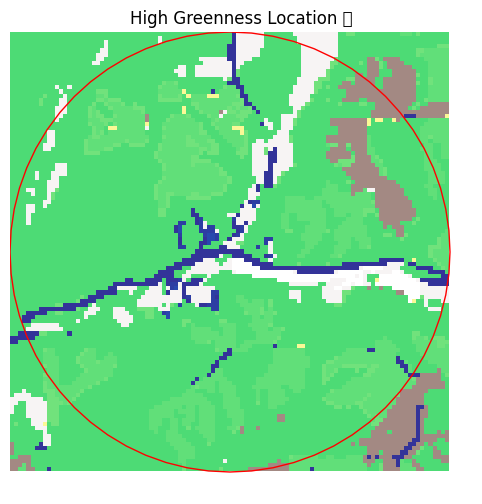

C:\Users\sybox\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


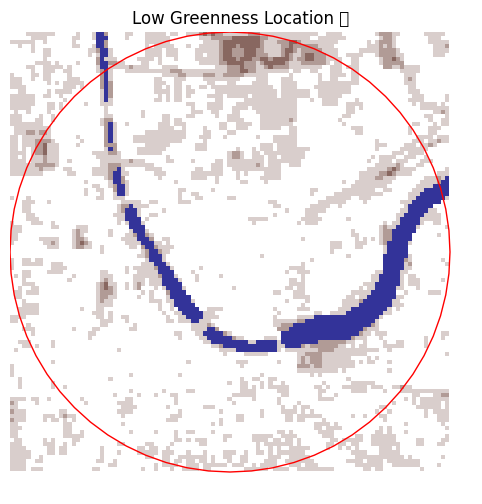

In [4]:
import pandas as pd
import rasterio
from rasterio.plot import show
from shapely.geometry import Point
import geopandas as gpd
import matplotlib.pyplot as plt

# --- Step 1: Load both datasets ---
g = pd.read_excel('greenness_results_2022_forest.xlsx')
addresses = pd.read_csv(r"C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Raw_2022_wAddress.csv")

# Merge by row order (they correspond one-to-one)
merged = pd.concat([addresses.reset_index(drop=True), g.reset_index(drop=True)], axis=1)

# --- Step 2: Pick one green and one less green location ---
high_idx = merged['green_percentage'].idxmax()
low_idx = merged['green_percentage'].idxmin()

high_green = merged.loc[high_idx]
low_green = merged.loc[low_idx]

print("High greenness example:")
print(high_green[['ADDRESS', 'LATITUDE', 'LONGITUDE', 'green_percentage']])
print("\nLow greenness example:")
print(low_green[['ADDRESS', 'LATITUDE', 'LONGITUDE', 'green_percentage']])

# --- Step 3: Visualization function ---
nlcd_file = r"C:\Users\sybox\NIJ Detroit\Annual_NLCD_LndCov_2022_CU_C1V1.tif"

def plot_greenness(lat, lon, title):
    with rasterio.open(nlcd_file) as src:
        gdf = gpd.GeoDataFrame(geometry=[Point(lon, lat)], crs='EPSG:4326').to_crs(src.crs)
        buffer = gdf.buffer(1609.34)  # 1 mile in meters
        bounds = buffer.total_bounds
        window = rasterio.windows.from_bounds(*bounds, src.transform)
        data = src.read(1, window=window)

        fig, ax = plt.subplots(figsize=(6, 6))
        show(data, ax=ax, transform=src.window_transform(window), cmap='terrain')
        buffer.boundary.plot(ax=ax, color='red', linewidth=1)
        plt.title(title)
        plt.axis('off')
        plt.show()

# --- Step 4: Plot both ---
plot_greenness(high_green['LATITUDE'].iloc[0], high_green['LONGITUDE'].iloc[0], "High Greenness Location 🌳")
plot_greenness(low_green['LATITUDE'].iloc[0], low_green['LONGITUDE'].iloc[0], "Low Greenness Location 🏙️")

In [6]:
# Replace these with your coordinates
high_lat, high_lon = high_green['LATITUDE'].iloc[0], high_green['LONGITUDE'].iloc[0]
low_lat, low_lon = low_green['LATITUDE'].iloc[0], low_green['LONGITUDE'].iloc[0]

# Create Google Maps URLs
high_url = f"https://www.google.com/maps?q={high_lat},{high_lon}"
low_url = f"https://www.google.com/maps?q={low_lat},{low_lon}"

print("High greenness location (Google Maps):", high_url)
print("Low greenness location (Google Maps):", low_url)


High greenness location (Google Maps): https://www.google.com/maps?q=36.41634231,-87.90943581
Low greenness location (Google Maps): https://www.google.com/maps?q=40.74029765,-74.15773819


### -Old code for HAWK

In [5]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
from shapely.geometry import Point
import geopandas as gpd
import time

# File paths
excel_file = r"C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Raw_HAWK_2022.csv.xlsx"
nlcd_file = r"C:\Users\sybox\NIJ Detroit\Annual_NLCD_LndCov_2022_CU_C1V1.tif"
output_file = 'greenness_results_simple.xlsx'

# Green land cover classes
GREEN_CLASSES = {
    21: "Developed, Open Space",
    41: "Deciduous Forest",
    42: "Evergreen Forest", 
    43: "Mixed Forest",
    52: "Shrub/Scrub",
    71: "Grassland/Herbaceous",
    81: "Pasture/Hay",
    82: "Cultivated Crops"
}

print("📂 Reading Excel file...")
df = pd.read_excel(excel_file)
print(f"✅ Found {len(df)} addresses")
print(f"📋 Columns: {df.columns.tolist()}")

# Check coordinates
print(f"\n🔍 Checking coordinates...")
print(f"  LATITUDE range: {df['LATITUDE'].min():.4f} to {df['LATITUDE'].max():.4f}")
print(f"  LONGITUDE range: {df['LONGITUDE'].min():.4f} to {df['LONGITUDE'].max():.4f}")

# Initialize results list
results = []
errors = []
successes = 0

print(f"\n🌱 Starting greenness analysis...")
print("This should take about 20-30 seconds per address (10-15 minutes total for 500)")
print("=" * 50)

start_time = time.time()
radius_meters = 1609.34  # 1 mile in meters

# Open NLCD file once
with rasterio.open(nlcd_file) as src:
    nlcd_crs = src.crs
    print(f"📊 NLCD CRS: {nlcd_crs}")
    
    for idx, row in df.iterrows():
        # Progress indicator with timing
        if idx % 10 == 0:
            elapsed = time.time() - start_time
            if idx > 0:
                rate = elapsed / idx
                remaining = (len(df) - idx) * rate
                print(f"Processing {idx+1}/{len(df)}... (~{remaining/60:.1f} minutes remaining)")
            else:
                print(f"Processing {idx+1}/{len(df)}...")
        
        try:
            # Get coordinates
            lat = float(row['LATITUDE'])
            lon = float(row['LONGITUDE'])
            
            # Create point and buffer
            point = Point(lon, lat)
            gdf = gpd.GeoDataFrame([1], geometry=[point], crs='EPSG:4326')
            
            # Transform to NLCD CRS
            gdf_albers = gdf.to_crs(nlcd_crs)
            buffer = gdf_albers.buffer(radius_meters)
            
            # Get window for this location
            bounds = buffer.total_bounds
            window = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], src.transform)
            
            # Check if window is within raster bounds
            if window.col_off < 0 or window.row_off < 0:
                errors.append(f"Row {idx}: Location outside NLCD coverage")
                results.append(np.nan)
                continue
                
            # Read only the needed portion
            local_data = src.read(1, window=window)
            
            if local_data.size == 0:
                errors.append(f"Row {idx}: No data at this location")
                results.append(np.nan)
                continue
                
            local_transform = src.window_transform(window)
            
            # Create temporary raster for masking
            from rasterio.io import MemoryFile
            with MemoryFile() as memfile:
                profile = src.profile.copy()
                profile.update({
                    'height': local_data.shape[0],
                    'width': local_data.shape[1],
                    'transform': local_transform,
                    'dtype': 'int32'
                })
                
                with memfile.open(**profile) as temp_src:
                    temp_src.write(local_data.astype(np.int32), 1)
                    
                    # Mask with buffer
                    clipped_data, _ = mask(temp_src, buffer.geometry, crop=True, nodata=0)
                    clipped_data = clipped_data[0]
            
            # Calculate greenness
            valid_pixels = clipped_data[clipped_data != 0]
            
            if len(valid_pixels) == 0:
                errors.append(f"Row {idx}: No valid pixels in buffer")
                results.append(np.nan)
                continue
                
            total_pixels = len(valid_pixels)
            green_pixels = np.sum(np.isin(valid_pixels, list(GREEN_CLASSES.keys())))
            green_percentage = (green_pixels / total_pixels) * 100
            
            results.append(round(green_percentage, 2))
            successes += 1
            
            # Debug info for first successful location
            if successes == 1:
                print(f"\n  ✅ First successful analysis:")
                print(f"     Location: ({lat:.4f}, {lon:.4f})")
                print(f"     Total pixels: {total_pixels}")
                print(f"     Green pixels: {green_pixels}")
                print(f"     Green %: {green_percentage:.2f}%")
                print(f"     Continuing with remaining addresses...\n")
                
        except Exception as e:
            errors.append(f"Row {idx}: {str(e)[:50]}")
            results.append(np.nan)

# Create output with only green_percentage column
output_df = pd.DataFrame({'green_percentage': results})

# Save results
output_df.to_excel(output_file, index=False)

# Print summary
total_time = time.time() - start_time
print(f"\n" + "="*50)
print(f"✅ Analysis complete!")
print(f"⏱️  Total time: {total_time/60:.1f} minutes ({total_time/len(df):.1f} seconds per address)")
print(f"📊 Results saved to: {output_file}")
print(f"✅ Successful analyses: {successes}/{len(df)}")

if successes > 0:
    green_values = [r for r in results if not pd.isna(r)]
    print(f"🌱 Average greenness: {np.mean(green_values):.1f}%")
    print(f"   Min: {np.min(green_values):.1f}%")
    print(f"   Max: {np.max(green_values):.1f}%")
    print(f"   Median: {np.median(green_values):.1f}%")

# Show first few errors if any
if errors:
    print(f"\n⚠️  Found {len(errors)} errors. First few:")
    for error in errors[:5]:
        print(f"   {error}")

print(f"\n💡 Output file contains only the 'green_percentage' column as requested.")

📂 Reading Excel file...
✅ Found 511 addresses
📋 Columns: ['RECRUITER_ID', 'SEED_ID', 'WAVE', 'SEED', 'SEED_MAIL', 'C1_0', 'C1_1', 'C2', 'C3', 'C4', 'C5', 'C11', 'C6', 'C7', 'C8', 'C9', 'C10', 'C13_1', 'C14_1', 'C15_1', 'C16_1', 'C17_1', 'C13_2', 'C14_2', 'C15_2', 'C16_2', 'C17_2', 'C13_3', 'C14_3', 'C15_3', 'C16_3', 'C17_3', 'C13_4', 'C14_4', 'C15_4', 'C16_4', 'C17_4', 'E5_1_1', 'E5_1_2', 'E5_EX_1', 'E5_EX_2', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'A2', 'A2_REL', 'AGE', 'SEX', 'B2', 'B4', 'B5', 'B7', 'N3', 'BMI', 'E1', 'E2', 'CV1', 'CV1_1', 'CV3_ANSWERED', 'CV3_MASK', 'CV3_WASH_HANDS', 'CV3_HAND_SANITIZER', 'CV3_GLOVES', 'CV3_MIN_OUTINGS', 'CV3_DISINFECT_HOUSE', 'CV3_SOCIAL_DIST', 'CV3_STAY_HOME', 'CV3_AVOID_TOUCH_FACE', 'CV3_VITAMINS', 'CV3_TYLENOL_ASPIRIN', 'CV3_NO_PREVENT', 'CV4_ANSWERED', 'CV4_NO_HEALTHCARE', 'CV4_LOST_JOB', 'CV4_WORK_HOME', 'CV4_LOST_INCOME', 'CV4_DISRUPT_EDUCATION', 'CV4_WORRY_GOTO_WORK', 'CV4_FACE_DISCRIMINATION', 'CV4_IMPACT_ACTIVITIES', 'CV4_IM

### Using HAWK addresses-Greenness (Developed space only)

In [2]:
import pandas as pd
import numpy as np
import rasterio
from rasterio.mask import mask
from rasterio.windows import from_bounds
from shapely.geometry import Point
import geopandas as gpd
import time
from rasterio.io import MemoryFile

def run_analysis(address_file, nlcd_file, output_file, green_classes, radius_meters=1609.34):
    print(f"\n📂 Reading address file: {address_file}")
    df = pd.read_csv(address_file)
    print(f"✅ Found {len(df)} addresses")
    print(f"📋 Columns: {df.columns.tolist()}")
    
    print(f"\n🔍 Checking coordinates...")
    print(f"  LATITUDE range: {df['LATITUDE'].min():.4f} to {df['LATITUDE'].max():.4f}")
    print(f"  LONGITUDE range: {df['LONGITUDE'].min():.4f} to {df['LONGITUDE'].max():.4f}")

    results = []
    errors = []
    successes = 0

    print(f"\n🌱 Starting 'Developed Open Space' analysis for {output_file} ...")
    print("=" * 50)
    start_time = time.time()

    with rasterio.open(nlcd_file) as src:
        nlcd_crs = src.crs
        print(f"📊 NLCD CRS: {nlcd_crs}")
        
        for idx, row in df.iterrows():
            if idx % 10 == 0:
                elapsed = time.time() - start_time
                if idx > 0:
                    rate = elapsed / idx
                    remaining = (len(df) - idx) * rate
                    print(f"Processing {idx+1}/{len(df)}... (~{remaining/60:.1f} min remaining)")
                else:
                    print(f"Processing {idx+1}/{len(df)}...")
            try:
                lat = float(row['LATITUDE'])
                lon = float(row['LONGITUDE'])
                point = Point(lon, lat)
                gdf = gpd.GeoDataFrame([1], geometry=[point], crs='EPSG:4326')
                gdf_albers = gdf.to_crs(nlcd_crs)
                buffer = gdf_albers.buffer(radius_meters)
                bounds = buffer.total_bounds
                window = from_bounds(bounds[0], bounds[1], bounds[2], bounds[3], src.transform)
                if window.col_off < 0 or window.row_off < 0:
                    errors.append(f"Row {idx}: Location outside NLCD coverage")
                    results.append(np.nan)
                    continue
                local_data = src.read(1, window=window)
                if local_data.size == 0:
                    errors.append(f"Row {idx}: No data at this location")
                    results.append(np.nan)
                    continue
                local_transform = src.window_transform(window)
                with MemoryFile() as memfile:
                    profile = src.profile.copy()
                    profile.update({
                        'height': local_data.shape[0],
                        'width': local_data.shape[1],
                        'transform': local_transform,
                        'dtype': 'int32'
                    })
                    with memfile.open(**profile) as temp_src:
                        temp_src.write(local_data.astype(np.int32), 1)
                        clipped_data, _ = mask(temp_src, buffer.geometry, crop=True, nodata=0)
                        clipped_data = clipped_data[0]
                valid_pixels = clipped_data[clipped_data != 0]
                if len(valid_pixels) == 0:
                    errors.append(f"Row {idx}: No valid pixels in buffer")
                    results.append(np.nan)
                    continue
                total_pixels = len(valid_pixels)
                green_pixels = np.sum(np.isin(valid_pixels, list(green_classes.keys())))
                green_percentage = (green_pixels / total_pixels) * 100
                results.append(round(green_percentage, 2))
                successes += 1
                if successes == 1:
                    print(f"\n  ✅ First successful analysis for {output_file}:")
                    print(f"     Location: ({lat:.4f}, {lon:.4f})")
                    print(f"     Total pixels: {total_pixels}")
                    print(f"     Open space pixels: {green_pixels}")
                    print(f"     Open space %: {green_percentage:.2f}%")
            except Exception as e:
                errors.append(f"Row {idx}: {str(e)[:50]}")
                results.append(np.nan)
        output_df = pd.DataFrame({'open_space_percentage': results})
        output_df.to_excel(output_file, index=False)
        total_time = time.time() - start_time
        print(f"\n" + "="*50)
        print(f"✅ Analysis complete for {output_file}!")
        print(f"⏱️  Total time: {total_time/60:.1f} min ({total_time/len(df):.1f}s/address)")
        print(f"✅ Successful analyses: {successes}/{len(df)}")
        if successes > 0:
            open_space_values = [r for r in results if not pd.isna(r)]
            print(f"🌳 Open space average: {np.mean(open_space_values):.1f}%")
            print(f"   Min: {np.min(open_space_values):.1f}%")
            print(f"   Max: {np.max(open_space_values):.1f}%")
            print(f"   Median: {np.median(open_space_values):.1f}%")
        if errors:
            print(f"\n⚠️  Found {len(errors)} errors. First few:")
            for error in errors[:5]:
                print(f"   {error}")
        print(f"\n💡 Output file contains only the 'open_space_percentage' column for {output_file}.")

# Only 'Developed, Open Space' class
GREEN_OPEN_SPACE_CLASS = {21: "Developed, Open Space"}

# File paths for both years
address_file_2022 = r"C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Raw_2022_wAddress.csv"
nlcd_file_2022 = r"C:\Users\sybox\NIJ Detroit\Annual_NLCD_LndCov_2022_CU_C1V1.tif"
output_file_2022 = 'open_space_results_2022.xlsx'

address_file_2023 = r"C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Raw_2023_wAddress.csv"
nlcd_file_2023 = r"C:\Users\sybox\NIJ Detroit\Annual_NLCD_LndCov_2023_CU_C1V1.tif"
output_file_2023 = 'open_space_results_2023.xlsx'

# Run for 2022
run_analysis(address_file_2022, nlcd_file_2022, output_file_2022, GREEN_OPEN_SPACE_CLASS)

# Run for 2023
run_analysis(address_file_2023, nlcd_file_2023, output_file_2023, GREEN_OPEN_SPACE_CLASS)


📂 Reading address file: C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Raw_2022_wAddress.csv
✅ Found 511 addresses
📋 Columns: ['RECRUITER_ID', 'SEED_ID', 'WAVE', 'SEED', 'SEED_MAIL', 'C1_0', 'C1_1', 'C2', 'C3', 'C4', 'C5', 'C11', 'C6', 'C7', 'C8', 'C9', 'C10', 'C13_1', 'C14_1', 'C15_1', 'C16_1', 'C17_1', 'C13_2', 'C14_2', 'C15_2', 'C16_2', 'C17_2', 'C13_3', 'C14_3', 'C15_3', 'C16_3', 'C17_3', 'C13_4', 'C14_4', 'C15_4', 'C16_4', 'C17_4', 'E5_1_1', 'E5_1_2', 'E5_EX_1', 'E5_EX_2', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'A2', 'A2_REL', 'AGE', 'SEX', 'B2', 'B4', 'B5', 'B7', 'N3', 'BMI', 'E1', 'E2', 'CV1', 'CV1_1', 'CV3_ANSWERED', 'CV3_MASK', 'CV3_WASH_HANDS', 'CV3_HAND_SANITIZER', 'CV3_GLOVES', 'CV3_MIN_OUTINGS', 'CV3_DISINFECT_HOUSE', 'CV3_SOCIAL_DIST', 'CV3_STAY_HOME', 'CV3_AVOID_TOUCH_FACE', 'CV3_VITAMINS', 'CV3_TYLENOL_ASPIRIN', 'CV3_NO_PREVENT', 'CV4_ANSWERED', 'CV4_NO_HEALTHCARE', 'CV4_LOST_JOB', 'CV4_WORK_HOME', 'CV4_LOST_INCOME', 'CV4_DISRUPT_EDUCATION', 'CV4_WORRY_GOTO

### Walk Score

In [7]:
!pip install --quiet tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: C:\Users\sybox\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import pandas as pd
import requests
import time
from tqdm import tqdm

API_KEY = '823ebf192a9537ddb2cbb92ea29ff225'
INPUT_CSV = r"C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\Combined.csv"
OUTPUT_CSV = r"C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\walkscore.csv"

# Read input data
df = pd.read_csv(INPUT_CSV)

results = []

# Loop with progress bar
for row in tqdm(df.itertuples(index=False), total=len(df), desc="Fetching Walk Scores"):
    address = row.ADDRESS
    lat = row.LATITUDE
    lon = row.LONGITUDE

    # Skip missing coordinates
    if pd.isna(lat) or pd.isna(lon):
        results.append({
            'ADDRESS': address, 'LATITUDE': lat, 'LONGITUDE': lon,
            'walkscore': 'Missing coordinates', 'walk_desc': '',
            'transit_score': '', 'transit_desc': '',
            'bike_score': '', 'bike_desc': '', 'ws_link': ''
        })
        continue

    url = (
        f"https://api.walkscore.com/score"
        f"?format=json"
        f"&address={requests.utils.quote(str(address))}"
        f"&lat={lat}"
        f"&lon={lon}"
        "&transit=1"
        "&bike=1"
        f"&wsapikey={API_KEY}"
    )

    try:
        response = requests.get(url, timeout=10)
        data = response.json()

        if data.get('status') == 1:
            result = {
                'ADDRESS': address,
                'LATITUDE': lat,
                'LONGITUDE': lon,
                'walkscore': data.get('walkscore'),
                'walk_desc': data.get('description'),
                'transit_score': data.get('transit', {}).get('score'),
                'transit_desc': data.get('transit', {}).get('description'),
                'bike_score': data.get('bike', {}).get('score'),
                'bike_desc': data.get('bike', {}).get('description'),
                'ws_link': data.get('ws_link')
            }
        elif data.get('status') == 2:
            result = {'ADDRESS': address, 'LATITUDE': lat, 'LONGITUDE': lon,
                      'walkscore': 'Calculating', 'walk_desc': '',
                      'transit_score': '', 'transit_desc': '',
                      'bike_score': '', 'bike_desc': '', 'ws_link': data.get('ws_link')}
        else:
            result = {'ADDRESS': address, 'LATITUDE': lat, 'LONGITUDE': lon,
                      'walkscore': 'Unavailable', 'walk_desc': '',
                      'transit_score': '', 'transit_desc': '',
                      'bike_score': '', 'bike_desc': '', 'ws_link': data.get('ws_link')}

    except Exception as e:
        result = {'ADDRESS': address, 'LATITUDE': lat, 'LONGITUDE': lon,
                  'walkscore': 'API Error', 'walk_desc': '',
                  'transit_score': '', 'transit_desc': '',
                  'bike_score': '', 'bike_desc': '', 'ws_link': 'https://www.walkscore.com/'}

    results.append(result)

    # Save progress every 50 rows
    if len(results) % 50 == 0:
        pd.DataFrame(results).to_csv(OUTPUT_CSV, index=False)

    time.sleep(0.5)  # half-second delay is enough

# Final save
pd.DataFrame(results).to_csv(OUTPUT_CSV, index=False)
print(f"✅ Done! Results saved to {OUTPUT_CSV}")


Fetching Walk Scores: 100%|████████████████████████████| 742/742 [12:21<00:00,  1.00it/s]

✅ Done! Results saved to C:\Users\sybox\MPSDS-RA\MAPOR2025\HAWK-data\walkscore.csv
